In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV

from lifelines.utils import concordance_index


In [106]:
# Load the data
df = pd.read_csv(r"C:\Users\jeheo\Desktop\School\5.Second Semester\Hands on Machine Learning\HOMLL\data\raw\wpbc_labeled.data", header=1)

In [107]:
# Check the data
df.head()

,Measures,ID_nummer,Outcome,Time,Mean,SE,Worst,Mean.1,SE.1,Worst.1,...,SE.7,Worst.7,Mean.8,SE.8,Worst.8,Mean.9,SE.9,Worst.9,Tum_Size,Lymp_stat
0,0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


## Preprocessing the data for RSF

In [108]:
## Preprocessing the data
def to_censored(Outcome):
    """
    The data has N and R as non-reccurent and reccurent.
    Threfore, we have to change that as integer, 1, 0
    """
    Outcome = str(Outcome)
    if Outcome == "N":
        return 0.0
    else:
        return 1.0
    
df["Censored"] = df["Outcome"].apply(to_censored)

In [109]:
# select the cols of data as X and Y
Y = df.loc[:,["Censored","Time"]]
X = df.drop(["Time", "Censored", "Outcome","ID_nummer", "Measures"], axis=1)


In [110]:
# Check the data types to prevent the error data type
X.dtypes

Mean         float64
SE           float64
Worst        float64
Mean.1       float64
SE.1         float64
Worst.1      float64
Mean.2       float64
SE.2         float64
Worst.2      float64
Mean.3       float64
SE.3         float64
Worst.3      float64
Mean.4       float64
SE.4         float64
Worst.4      float64
Mean.5       float64
SE.5         float64
Worst.5      float64
Mean.6       float64
SE.6         float64
Worst.6      float64
Mean.7       float64
SE.7         float64
Worst.7      float64
Mean.8       float64
SE.8         float64
Worst.8      float64
Mean.9       float64
SE.9         float64
Worst.9      float64
Tum_Size     float64
Lymp_stat     object
dtype: object

In [111]:
# We found the weird data type, therefore, we deciede to replace it with mode because the data predominant with its mode
X["Lymp_stat"].mode() 

0    0
dtype: object

In [112]:
# I checked the data and found out "?" is problem
j = 0
for i in X["Lymp_stat"]:
    if i == "?":
        print(j)
    j += 1

6
28
85
196


In [113]:
# replace "?" to "0" for further process
X["Lymp_stat"].replace({"?": "0"}, inplace=True)

In [114]:
# check the results
j = 0
for i in X["Lymp_stat"]:
    if i == "?":
        print(j)
    j += 1

In [115]:
# Change data type from list to array
X = np.array(X.values)

In [116]:
# function allows only this data type so I changed it
Yt = []
for x in Y.values:
    Yt.append(tuple(x))
    
Y = np.array(Yt, dtype=[('cens', '?'), ('time', '<f8')])

In [117]:
# split the data X and Y into train set, test set and yousing stratified.

random_state = 10

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=random_state, stratify=Y["cens"])

In [118]:
# Check the shape of the data
X_train.shape, X_test.shape

((158, 32), (40, 32))

In [119]:
Y_train.shape, Y_test.shape

((158,), (40,))

## Train the model RSF

In [120]:
# Set to the all parameter as default and instantiate the model
rsf = RandomSurvivalForest(random_state=random_state)

# Put the train data into the model
rsf.fit(X_train, Y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=10, verbose=0, warm_start=False)

In [121]:
# I will pick the best model by training randomly and get the best model

def train_model(
    X_train,
    Y_train,
    X_val,
    Y_val,
    epoch = 50,
    n_estimators=100,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features="auto",
    n_jobs=None
):
    """
    Get the data and parameter and epoch of RSF model.
    Randomly train the model with train data sets
    Evaluate the model with the test data sts
    Get score and save the best model
    """
    best_accuracy = 0
    rsf = RandomSurvivalForest(n_estimators=100,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features="auto",
    n_jobs=None)
    for i in range(epoch):
        rsf.fit(X_train, Y_train) # train the model
        acc = rsf.score(X_val, Y_val) # get score
        print(f"Current Epoch: {i+1}/{epoch}")
        print(f"Accuracy: {acc}")
        if acc > best_accuracy:
            best_rsf = rsf# save model
    return best_rsf

## Grid Search

In [87]:
parameters = {'n_estimators':[100, 300, 500, 1000], "max_features": ["sqrt"], "max_depth":[5,10,20,40,80] } # We build parameter dictionary
rsf = RandomSurvivalForest(random_state=random_state) # What model we are goint to test
clf = GridSearchCV(rsf, parameters, cv=5) # Upload it to Grid Search CV, it is statified.

clf.fit(X_train, Y_train) # fit the model

sorted(clf.cv_results_.keys()) # check the results

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_max_features',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [88]:
clf.cv_results_["rank_test_score"]

array([12, 10,  1,  6, 13, 17,  2, 11, 13, 17,  2,  7, 13, 17,  2,  7, 13,
       17,  2,  7])

In [92]:
clf.cv_results_["params"][2] # get the parmeter from rank 1

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}

In [90]:
clf.cv_results_

{'mean_fit_time': array([0.54005036, 1.59143448, 2.69095335, 5.53633037, 0.60202703,
        1.85047364, 3.03915834, 6.03283439, 0.60551858, 1.78136334,
        3.02348909, 5.99340143, 0.59443908, 1.85251966, 3.03502364,
        6.10192771, 0.60028086, 1.82716537, 3.07997341, 6.14248986]),
 'std_fit_time': array([0.03568499, 0.05920443, 0.12149516, 0.22398863, 0.03673856,
        0.10730936, 0.09840615, 0.23929912, 0.02308474, 0.03934497,
        0.08787302, 0.1565228 , 0.03695852, 0.06513143, 0.1067944 ,
        0.32818854, 0.0372239 , 0.12488361, 0.1344394 , 0.24433026]),
 'mean_score_time': array([0.00758309, 0.01950188, 0.02978654, 0.06816535, 0.00757551,
        0.02174015, 0.03481159, 0.07171168, 0.00798402, 0.02233429,
        0.03348227, 0.06561861, 0.00796709, 0.02064996, 0.03152299,
        0.06320519, 0.00777345, 0.02133203, 0.03610005, 0.08057737]),
 'std_score_time': array([0.0007897 , 0.00281878, 0.00131226, 0.0062421 , 0.00101076,
        0.00075329, 0.00422635, 0.008265

## Evaluate the model with validation sets

In [122]:
rsf = RandomSurvivalForest(random_state=random_state, max_depth= 5, max_features="sqrt" , n_estimators=500)
rsf.fit(X_train,Y_train)

RandomSurvivalForest(bootstrap=True, max_depth=5, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=500, n_jobs=None, oob_score=False,
                     random_state=10, verbose=0, warm_start=False)

In [123]:
rsf.score(X_train,Y_train)

0.9489625566420224

## Plot the results

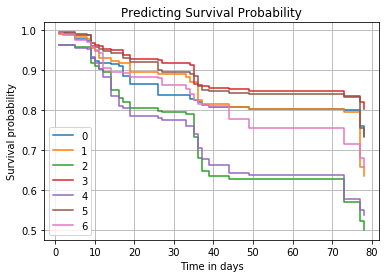

In [124]:
# plot the survival probability

surv = rsf.predict_survival_function(X_test[0:7], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.title("Predicting Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

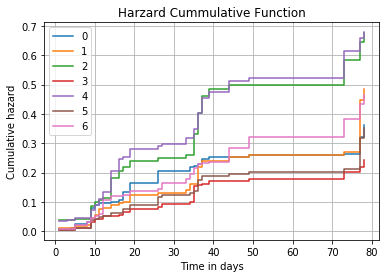

In [125]:
# plot the hazard cummulative function

surv = rsf.predict_cumulative_hazard_function(X_test[0:7], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.title("Harzard Cummulative Function")
plt.grid(True)
plt.legend()
plt.show()

## Cox Regression is Penalized Elastic Net

## Train the Model

In [126]:
CSA = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
CSA.fit(X_train, Y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio='auto', alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=0.99, max_iter=100000,
                       n_alphas=100, normalize=False, penalty_factor=None,
                       tol=1e-07, verbose=False)

## Grid Search

In [127]:
from sklearn.model_selection import GridSearchCV


parameters = {'l1_ratio':[0.01, 0.05, 0.10, 0.30, 0.50, 0.80, 0.9, 0.99], 'fit_baseline_model':[True, False]} # We build parameter dictionary
CSA = CoxnetSurvivalAnalysis() # What model we are goint to test
clf = GridSearchCV(CSA, parameters, cv=5) # Upload it to Grid Search CV

clf.fit(X_train, Y_train) # fit the model

sorted(clf.cv_results_.keys()) # check the results

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_fit_baseline_model',
 'param_l1_ratio',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [128]:
clf.cv_results_["rank_test_score"]

array([ 1,  3,  5,  7,  9, 13, 13, 11,  1,  3,  5,  7,  9, 13, 13, 11])

In [129]:
clf.cv_results_["params"][0]

{'fit_baseline_model': True, 'l1_ratio': 0.01}

In [130]:
clf.cv_results_["params"][10]

{'fit_baseline_model': False, 'l1_ratio': 0.1}

In [151]:
clf.cv_results_

{'mean_fit_time': array([0.05236983, 0.04860997, 0.04807439, 0.0480042 , 0.05547371,
        0.05187044, 0.04907064, 0.05059342, 0.00493364, 0.0063756 ,
        0.00678949, 0.00738902, 0.00818114, 0.0085948 , 0.0081255 ,
        0.00856285]),
 'std_fit_time': array([0.02353339, 0.02012968, 0.0194905 , 0.0197181 , 0.02408408,
        0.01927612, 0.02067511, 0.02150918, 0.00332557, 0.0045846 ,
        0.00509615, 0.00555223, 0.00616441, 0.00658209, 0.00634558,
        0.00658233]),
 'mean_score_time': array([0.0009954 , 0.00098867, 0.00052261, 0.00060081, 0.0010006 ,
        0.00079021, 0.00079713, 0.00060687, 0.00099268, 0.00100503,
        0.00098929, 0.00079689, 0.00058746, 0.00098681, 0.0007925 ,
        0.00081215]),
 'std_score_time': array([3.95228687e-06, 1.77389832e-05, 4.61141645e-04, 4.90580001e-04,
        2.27253806e-05, 3.95263566e-04, 3.98572250e-04, 4.95709773e-04,
        9.36180842e-06, 1.60075306e-05, 1.13989017e-05, 3.98551456e-04,
        4.79859572e-04, 1.60765561e-

## Evaluate the model with validation sets

In [135]:
# we got candidates of hyperparameter l1_ratio: 0.1, fit_baseline_mode: False, True

CSA = CoxnetSurvivalAnalysis(l1_ratio=0.01, fit_baseline_model=True)
CSA.fit(X_train, Y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio='auto', alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=0.01, max_iter=100000,
                       n_alphas=100, normalize=False, penalty_factor=None,
                       tol=1e-07, verbose=False)

In [136]:
CSA.score(X_train, Y_train)

0.6687336036250895

> The score is higher at Cox Regression penalized by Elastic Net. Cox Regression assume the data is divided by hyperplanes (linearity assumption) and RSF actually doesn't aussme the linearity of decision boundary. It is non-linear function. So if the data is more big, then the results will be different.I think this is often happened in the data science field because we can think the model is hypothesis. We are trying to get hypothesis correct based on given data. However, the given data is small, then the likelihood of the model will be spread and we can find other reasonable model based on given data. In this case, we have to get more data or we have to use the prior that we know about the data. Let's say some columns are dependent or data is skewed or medical reasoning.

$prior$ = $P(H|X)$, $posterior$ = $P(H|DX)$, $Likelihood$ = $P(D|HX)$, $Marginal$ = $P(D|X)$ , $H = Hypothesis$,$X = Every Back Ground Information$,  $D = Given data$

> $P(H|DX)$ = $P(H|X)$ * $\frac{P(D|HX)}{P(D|X)}$

## C index of each model

In [141]:
Y_test= pd.DataFrame(Y_test)

In [145]:
cindex = concordance_index(Y_test['time'], -rsf.predict(X_test), Y_test['cens'])

In [147]:
# cindex of rsf
cindex

0.6807511737089202

In [148]:
cindex = concordance_index(Y_test['time'], -CSA.predict(X_test), Y_test['cens'])

In [150]:
# cindex of Cox regression penalized by elastic net
cindex

0.7699530516431925